In [11]:
import pandas as pd
from IPython.display import Image
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

In [4]:
msmt_feedback = pd.read_csv("msmt_feedback_clean.csv")

In [5]:
msmt_feedback

,Unnamed: 0,measurement_uid,status,outcome
0,0,20240821111652.275207_RU_telegram_98b717d97593...,blocked,blocked
1,1,0120191024c9bee71f54e22e25cdbb7007cb825c,down.unreachable,down
2,2,20230306T235817Z_webconnectivity_BR_263087_n1_...,ok,ok
3,3,20230307235958.642565_FR_webconnectivity_86a52...,ok,ok
4,4,20230308T092114Z_webconnectivity_IR_49100_n1_e...,blocked.blockpage.dns,blocked
...,...,...,...,...
281,281,20240815092817.050941_DE_webconnectivity_66100...,ok,ok
282,282,20240815172949.387668_VE_webconnectivity_427ad...,blocked.tcp,blocked
283,283,20240818234433.791006_VE_webconnectivity_8fac0...,ok,ok
284,284,20240820000738.441114_US_dash_562a4dac7563a905,ok,ok


In [93]:
web_analysis_bn = BayesianNetwork([
    ('DNS Ctrl Failure', 'DNS Outcome'),
    ('DNS Ctrl Failure', 'DNS Answer Meta'),
    #('Resolver config', 'DNS Outcome'),
    ('DNS Consistency', 'DNS Outcome'),
    ('DNS Answer Meta', 'DNS Consistency'),
    ('DNS Answer Meta', 'DNS TLS Consistency'),
    ('DNS TLS Consistency', 'DNS Consistency'),
])

In [94]:
#web_analysis_bn.save('web_analysi.bif')

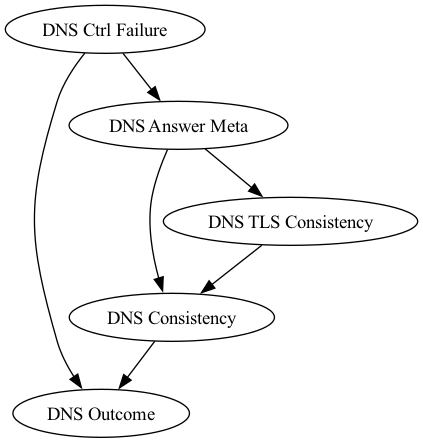

In [95]:
viz = web_analysis_bn.to_graphviz()
viz.draw('web_analysis_simple.png', prog='dot')
Image('web_analysis_simple.png')

In [57]:
def print_boilerplate():
    cpd_list = []
    for x in list(web_analysis_bn.nodes):
        var_name = x.lower().replace(' ', '_')
        var_name = f"cpd_{var_name}"
        s = f"{var_name} = TabularCPD('{x}', variable_card=2, values=[\n"
        parents = web_analysis_bn.get_parents(x)
        padding = " "*(int(len(s)/2))
        for _ in range(2):
            s += padding + "["
            s += ",".join("0." for x in range(len(parents)))
            s += "],\n"
        s += padding + f"],\n" 
        s += padding + f" # parents={parents}\n"
        s += padding + f"evidence={parents},\n"
        s += padding + f"evidence_card=[],\n"
        s += padding + "state_names = {\n"
        for p in parents:
            s += padding + f"'{p}': [],\n"
        s += "}\n"
        s += padding + ")"
        print(s)
        cpd_list.append(var_name)

In [80]:
cpd_resolver_config = TabularCPD(
    "Resolver config",
    variable_card=3,
    values=[
        # These values were estimated based on a query against the OONI dataset from 2024-01-01 to 2024-08-10
        # with this query:
        # -- ## quad_resolvers
        # --    15169, # Google LLC
        # --    13335, # Cloudflare Inc
        # --    42, # WoodyNet, Inc. | quad9
        # --    36692, # Cisco OpenDNS, LLC	
        # SELECT 
        # CountIf(resolver_asn IN (15169, 13335, 42, 36692)) as quad_external_count,
        # CountIf( 
        #     (resolver_asn = probe_asn OR resolver_as_cc = probe_cc) 
        #     AND NOT (resolver_asn IN (15169, 13335, 42, 36692)) 
        # ) as provider_vp_consistent,
        # CountIf( 
        #     (resolver_asn != probe_asn AND resolver_as_cc != probe_cc) 
        #     AND NOT (resolver_asn IN (15169, 13335, 42, 36692)) 
        # ) as provider_non_vp_consistent,
        # COUNT() as total_count
        # FROM obs_web
        # WHERE 
        # measurement_start_time > '2024-01-01' 
        # AND measurement_start_time < '2024-08-10'
        [0.56],
        [0.08],
        [0.36],
    ],
    state_names={
        # provider_vp_consistent: means the resolver is consistent with the country and/or AS of the probe and is 
        #   not a quad (eg. 8.8.8.8, 9.9.9.9, etc.) or third party resolver
        # provider_non_vp_consistent: means the resolver is not a quad resolver, 
        #   but is not consistent with the metadata of the probe
        # quad_external: means the resolver is something like quad9, google, cloudflare, etc.
        "Resolver config": ["provider_vp_consistent", "provider_non_vp_consistent", "quad_external"]
    },
)
cpd_dns_ctrl_failure = TabularCPD(
    "DNS Ctrl Failure",
    variable_card=3,
    values=[
        [0.994],
        [0.004],
        [0.002],
    ],
    state_names={
        "DNS Ctrl Failure": ["none", "nxdomain", "server_failure"]
    },
)
cpd_dns_answer_meta = TabularCPD(
    "DNS Answer Meta",
    variable_card=7,
    # These values were calculated using the following query.
    # WITH
    #     (dns_answer IS NOT NULL 
    #     AND ip_asn IN (13335, 209242, 20940, 9002, 16625, 63949, 16509, 14618, 15169, 396982, 54113, 8075, 8068)
    #     ) as is_cloud_provider
    # SELECT 
    # CountIf(is_cloud_provider) as cloud_provider,
    # CountIf(
    # dns_answer IS NOT NULL AND ip_is_bogon AND NOT is_cloud_provider
    # ) as answer_is_bogon,
    # CountIf(
    #     dns_answer IS NOT NULL AND ip_asn = probe_asn AND NOT is_cloud_provider
    # ) as answer_matches_probe_asn,
    # CountIf(
    #     dns_answer IS NOT NULL AND (ip_cc = probe_cc AND NOT ip_asn = probe_asn AND NOT is_cloud_provider)
    # ) as answer_matches_probe_cc,
    # CountIf(
    #     dns_answer IS NOT NULL AND (ip_cc != probe_cc AND ip_asn != probe_asn AND NOT ip_is_bogon AND NOT is_cloud_provider)
    # ) as answer_ok,
    # COUNTIf(dns_failure IS NOT NULL) as dns_failure,
    # COUNT() as total_count
    # FROM obs_web
    # WHERE 
    # test_name = 'web_connectivity'
    # AND measurement_start_time > '2024-01-01' 
    # AND measurement_start_time < '2024-08-10'
    ## The list of cloud providers was manually curated
    # CLOUD_PROVIDERS_ASNS = [
    #    13335,  # Cloudflare: https://www.peeringdb.com/net/4224
    #    209242, #	Cloudflare London, LLC	
    #    20940,  # Akamai: https://www.peeringdb.com/net/2
    #    9002,  # Akamai RETN
    #    16625, # Akamai Technologies, Inc.	
    #    63949, # Akamai Technologies, Inc.	
    #    16509, #	Amazon.com, Inc.
    #    14618, #	Amazon.com, Inc.	
    #    15169, #	Google LLC
    #    396982,  # Google Cloud: https://www.peeringdb.com/net/30878
    #    54113, #	Fastly, Inc
    #    8075, # Microsoft Corporation
    #    8068, #	Microsoft Corporation
    # ]
    values=[
        # "none", "nxdomain", "server_failure"
        [0.0238, 0.9, 0.015],
        [0.01, 0.03, 0.91],
        [0.003745, 0.014, 0.015],
        [0.004537, 0.014, 0.015],
        [0.060217, 0.014, 0.015],
        [0.19626, 0.014, 0.015],
        [0.700935, 0.014, 0.015]
    ],
    # parents={parents}
    evidence=["DNS Ctrl Failure"],
    evidence_card=[3],
    state_names={
        "DNS Answer Meta": [
            "answer_failure_nxdomain",
            "answer_failure_other",
            "answer_is_bogon", 
            "answer_matches_probe_asn", 
            "answer_matches_probe_cc",
            "answer_is_cloud_provider",
            "answer_ok"
        ],
        "DNS Ctrl Failure": ["none", "nxdomain", "server_failure"]
    },
)
cpd_dns_tls_consistency = TabularCPD(
    "DNS TLS Consistency",
    variable_card=3,
    values=[
        # answer_failure_nxdomain, answer_failure_other, answer_is_bogon, 
        # answer_matches_probe_asn, answer_matches_probe_cc, 
        # answer_is_cloud_provider, answer_ok,
        [0.96, 0.96, 0.0, 0.05, 0.05, 0.9, 0.94], # tls_consistent
        [0.02, 0.02, 0.02, 0.8, 0.8, 0.08, 0.04], # tls_inconsistent
        [0.02, 0.02, 0.98, 0.15, 0.15, 0.02, 0.02], # tls_connection_failed
        # [0.96],
        # [0.02],
        # [0.02]
    ],
    evidence=["DNS Answer Meta"],
    evidence_card=[7],
    state_names={
        "DNS TLS Consistency": ["tls_consistent", "tls_inconsistent", "tls_connection_failed"],
        "DNS Answer Meta": [
            "answer_failure_nxdomain",
            "answer_failure_other",
            "answer_is_bogon", 
            "answer_matches_probe_asn", 
            "answer_matches_probe_cc",
            "answer_is_cloud_provider",
            "answer_ok"
        ],
    },
)
cpd_dns_consistency = TabularCPD(
    "DNS Consistency",
    variable_card=2,
    values=[
        # answer_failure_nxdomain, answer_failure_other, answer_is_bogon, answer_matches_probe_asn, 
        # answer_matches_probe_cc, answer_is_cloud_provider, answer_ok
        # tls_consistent, tls_inconsistent, tls_connection_failed
        
        # answer_failure_nxdomain, tls_consistent, tls_inconsistent, tls_connection_failed
        [0.01, 0.001, 0.001,
        # answer_failure_other, tls_consistent, tls_inconsistent, tls_connection_failed
         0.01, 0.001, 0.001,
         # answer_is_bogon, , 
         0.03, 0.01, 0.01,
         # answer_matches_probe_asn
         0.999, 0.001, 0.3,
         # answer_matches_probe_cc
         0.999, 0.001, 0.2,
         # answer_is_cloud_provider
         0.98, 0.001, 0.1,
         # answer_ok
         0.9999, 0.01, 0.2 
        ],
        [0.99, 0.999, 0.999,
         # answer_failure_other, tls_consistent, tls_inconsistent, tls_connection_failed
         0.99, 0.999, 0.999,
         # answer_is_bogon,
         0.97, 0.99, 0.99,
         # answer_matches_probe_asn
         0.001, 0.999, 0.7,
         # answer_matches_probe_cc
         0.001, 0.999, 0.8,
         # answer_is_cloud_provider
         0.02, 0.999, 0.9,
         # answer_ok
         0.0001, 0.99, 0.8
         ],
    ],
    # parents={parents}
    evidence=["DNS Answer Meta", "DNS TLS Consistency"],
    evidence_card=[7, 3],
    state_names={
        "DNS Answer Meta": [
            "answer_failure_nxdomain",
            "answer_failure_other",
            "answer_is_bogon", 
            "answer_matches_probe_asn", 
            "answer_matches_probe_cc",
            "answer_is_cloud_provider",
            "answer_ok"
        ],
        "DNS TLS Consistency": ["tls_consistent", "tls_inconsistent", "tls_connection_failed"],
        "DNS Consistency": [
            "consistent",
            "inconsistent"
            # TODO(consistent UP and consistent DOWN)
        ],
    },
)
cpd_dns_outcome = TabularCPD(
    "DNS Outcome",
    variable_card=3,
    values=[
        # none, nxdomain, server_failure (ctrl failure)
        # consistent, inconsistent (consistency)
        # none, consistent, inconsistent
        [0.1, 0.9, 0.2, 0.8, 0.1, 0.7],
        [0.9, 0.1, 0.0, 0.0, 0.8, 0.1],
        [0.0, 0.0, 0.8, 0.2, 0.1, 0.2],
    ],
    evidence=[
        "DNS Ctrl Failure",
        "DNS Consistency",
    ],
    evidence_card=[3, 2],
    state_names={
        "DNS Outcome": [
            "blocked",
            "ok",
            "down"
        ],
        "DNS Ctrl Failure": ["none", "nxdomain", "server_failure"],
        "DNS Consistency": [
            "consistent",
            "inconsistent"
        ],
    },
)

In [81]:
web_analysis_bn.add_cpds(cpd_dns_ctrl_failure, cpd_dns_answer_meta, cpd_dns_tls_consistency, cpd_dns_consistency, cpd_dns_outcome)

In [82]:
web_analysis_bn.check_model()

True

In [83]:
from pgmpy.inference import VariableElimination

In [84]:
infer = VariableElimination(web_analysis_bn)

In [85]:
print(infer.query(['DNS Outcome']))

+----------------------+--------------------+
| DNS Outcome          |   phi(DNS Outcome) |
+======================+====================+
| DNS Outcome(blocked) |             0.2299 |
+----------------------+--------------------+
| DNS Outcome(ok)      |             0.7688 |
+----------------------+--------------------+
| DNS Outcome(down)    |             0.0013 |
+----------------------+--------------------+


In [86]:
print(g_dist)

+----------------------+--------------------+
| DNS Outcome          |   phi(DNS Outcome) |
+======================+====================+
| DNS Outcome(blocked) |             0.2176 |
+----------------------+--------------------+
| DNS Outcome(ok)      |             0.7812 |
+----------------------+--------------------+
| DNS Outcome(down)    |             0.0013 |
+----------------------+--------------------+


In [87]:
print(infer.query(
    ['DNS Outcome'], 
    evidence={
        #'DNS TLS Consistency': 'tls_inconsistent',
        "DNS Answer Meta": "answer_is_bogon", 
    }
))

+----------------------+--------------------+
| DNS Outcome          |   phi(DNS Outcome) |
+======================+====================+
| DNS Outcome(blocked) |             0.8890 |
+----------------------+--------------------+
| DNS Outcome(ok)      |             0.1064 |
+----------------------+--------------------+
| DNS Outcome(down)    |             0.0046 |
+----------------------+--------------------+


In [90]:
print(infer.query(
    ['DNS Outcome'], 
    evidence={
        'DNS TLS Consistency': 'tls_inconsistent',
        "DNS Answer Meta": "answer_is_cloud_provider", 
    }
))

+----------------------+--------------------+
| DNS Outcome          |   phi(DNS Outcome) |
+======================+====================+
| DNS Outcome(blocked) |             0.8991 |
+----------------------+--------------------+
| DNS Outcome(ok)      |             0.1008 |
+----------------------+--------------------+
| DNS Outcome(down)    |             0.0001 |
+----------------------+--------------------+
